In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
import os
import math

In [2]:
images_gray = []
images_rgb = []

folder_path = 'cap-inspection-images/project_2_cavity_number/'
file_names = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]

for file_name in file_names:
    file_path = os.path.join(folder_path, file_name)
    if file_path.endswith(('.bmp')):
        img = cv2.imread(file_path)
        images_rgb.append(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
        images_gray.append(cv2.cvtColor(img,cv2.COLOR_BGR2GRAY))
print('Loaded '+ str(len(images_gray))+ ' images!')

Loaded 29 images!


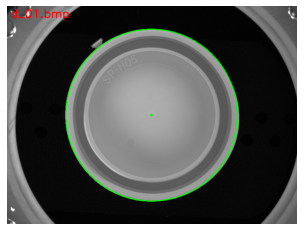

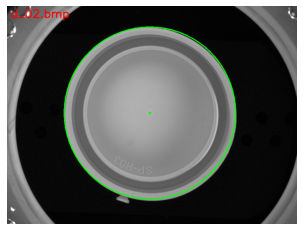

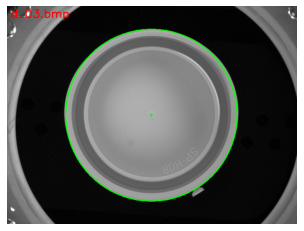

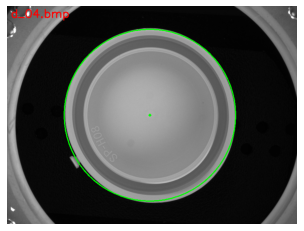

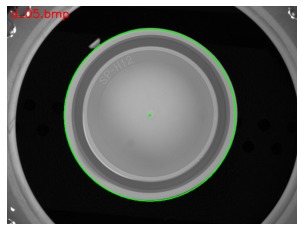

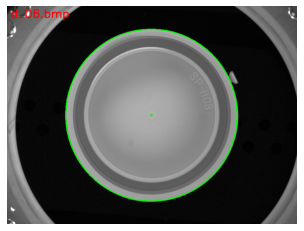

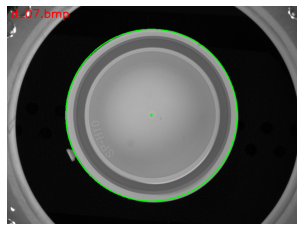

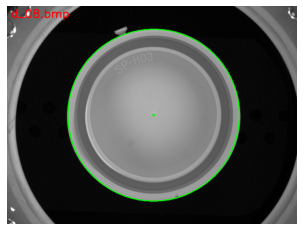

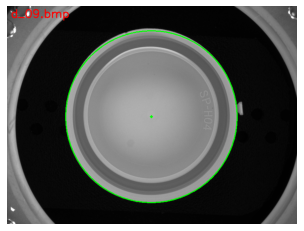

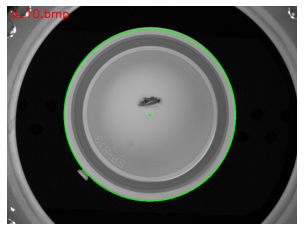

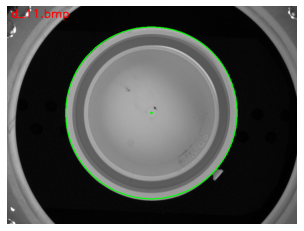

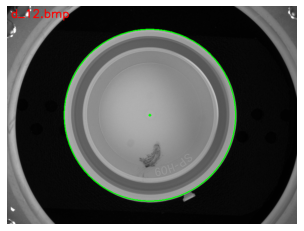

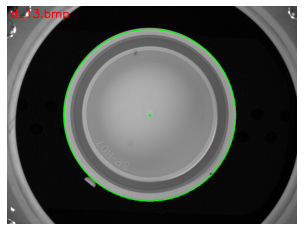

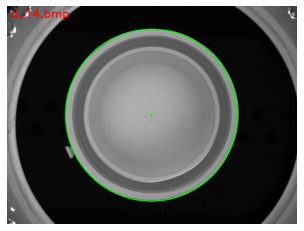

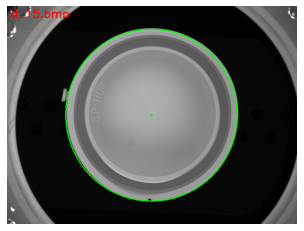

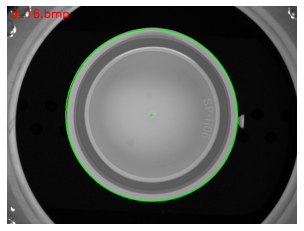

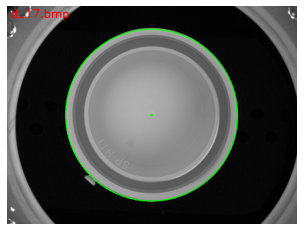

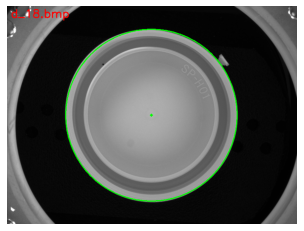

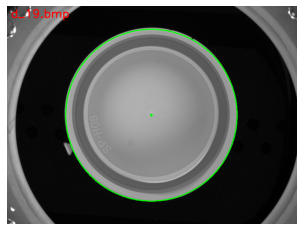

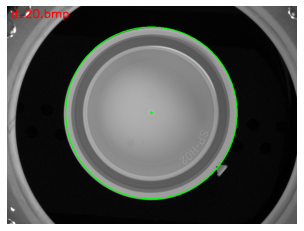

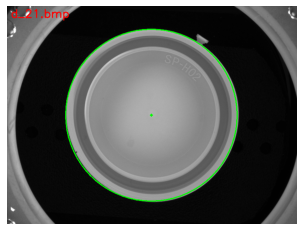

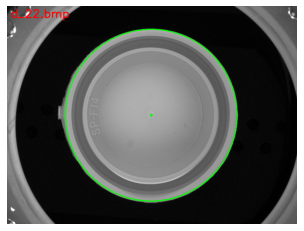

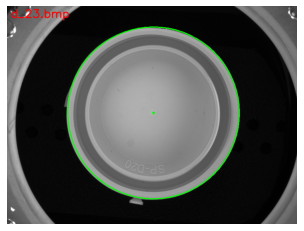

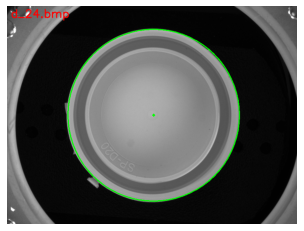

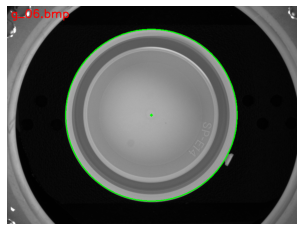

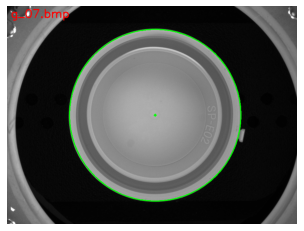

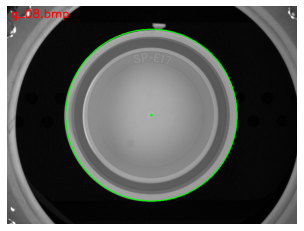

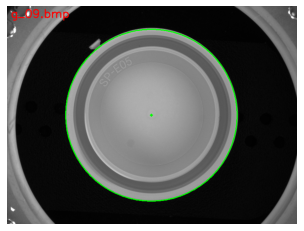

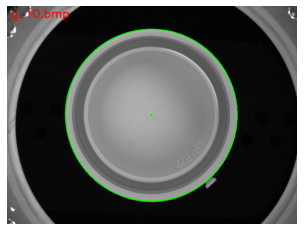

In [3]:
binary_image = []
cap_center = []
cap_circle_img = []

for index, img_gray in enumerate(images_gray):
    cap_circle_img.append(np.copy(images_rgb[index]))
    
    median_blur = cv2.medianBlur(img_gray, 3)  
    # plt.imshow(median_blur, cmap='gray')
    # plt.show()
    _, binary = cv2.threshold(median_blur, 30, 255, cv2.THRESH_BINARY)
    binary_image.append(binary)
    # plt.imshow(binary, cmap='gray')
    # plt.show()

    cap_circle = cv2.HoughCircles(binary, cv2.HOUGH_GRADIENT, dp=5, minDist=200,
                               param1=150,param2=100,minRadius=225,maxRadius=230)

    if cap_circle is not None:
        cap_circle = np.uint16(np.around(cap_circle))
        for i in cap_circle[0, :]:
            center = (i[0], i[1])
            radius = i[2]
            cap_center.append((center,radius))
            cv2.circle(cap_circle_img[index], center, radius, (0, 255, 0), 2)
            cv2.circle(cap_circle_img[index], center, 2, (0, 255, 0), 3)
    else:
        print("No cap circle detected.")
        
    cv2.putText(cap_circle_img[index], file_names[index], (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, 255, 2)
#     captext = f"Center:{cap_center[index][0][0],cap_center[index][0][1]}"
#     cv2.putText(cap_circle_img[index], captext, (10, 60), cv2.FONT_HERSHEY_SIMPLEX, 1, 255, 2)
#     radiustext = f"R:{cap_center[index][1]}"
#     cv2.putText(cap_circle_img[index], radiustext, (10, 90), cv2.FONT_HERSHEY_SIMPLEX, 1, 255, 2)
           
    plt.imshow(cap_circle_img[index], cmap='gray')
    plt.axis('off')
    plt.show()

In [4]:
mask_range = 20
masked_cap = []

binary_cap = []

for index, img_gray in enumerate(images_gray):
    mask = np.zeros_like(img_gray)
    cv2.circle(mask, (cap_center[index][0][0],cap_center[index][0][1]), 
               cap_center[index][1]+mask_range, 255, -1)
    masked_cap.append(cv2.bitwise_and(img_gray,mask))
#     plt.imshow(masked_cap[index], cmap='gray')
#     plt.show()


tab_line = []
tab_center = []
for index, m_cap in enumerate(masked_cap):
    _, binary_image = cv2.threshold(m_cap, 50, 255, cv2.THRESH_BINARY)
    binary_cap.append(binary_image)
#     plt.imshow(binary_image, cmap='gray')
#     plt.show()

    max_distance_threshold = cap_center[index][1]+10 
    tab_points = []
    tab_line.append(np.copy(images_rgb[index]))
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    if contours is not None:
        for contour in contours:
    #         cv2.drawContours(tab_line[index], [contour], -1, (255, 0, 0), 2)

            for point in contour:
                    px, py = point[0]
                    distance = np.sqrt((px - cap_center[index][0][0])**2 + 
                                       (py - cap_center[index][0][1])**2)
                    if distance > max_distance_threshold:
                        tab_points.append((px, py))
    #                     cv2.circle(tab_line[index], (px, py), 5, (0, 255, 255), -1)
    
        if tab_points is not None:
            tab_center.append((
                sum([point[0] for point in tab_points]) // len(tab_points),
                sum([point[1] for point in tab_points]) // len(tab_points)
            ))

            cv2.circle(tab_line[index], tab_center[index], 5, (0, 255, 0), -1)
    #         print("Center of tab:", tab_center[index])
        else:
            print("No tab_points found!")
        
        cv2.circle(tab_line[index], center, 5, (255, 0, 0), -1)            
    #     plt.imshow(tab_line[index])
    #     plt.show()
    else:
        print("No contours found!")
print('Finished finding tabs!')

Finished finding tabs!


In [5]:
rotate_angle = []
rotated_image = []

for index, m_cap in enumerate(masked_cap):
    rows, cols= m_cap.shape
    y2=tab_center[index][1]
    y1=cap_center[index][0][1]
    x2=tab_center[index][0]
    x1=cap_center[index][0][0]

    slope = (y2 - y1) / (x2 - x1)
    angle = math.atan(slope) * 180 / math.pi

    if x2 > x1:
        rotate_angle.append(angle+90)
    else:
        rotate_angle.append(angle-90)

#     print("rotate_angle:", rotate_angle[index])

    M = cv2.getRotationMatrix2D((x1, y1), rotate_angle[index], 1)
    rotated_image.append(cv2.warpAffine(m_cap, M, (cols, rows)))

#     plt.imshow(rotated_image[index], cmap='gray')
#     plt.show()
print('Finishen rotating images!')

Finishen rotating images!


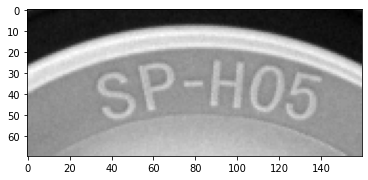

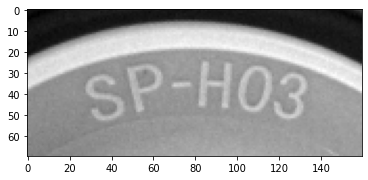

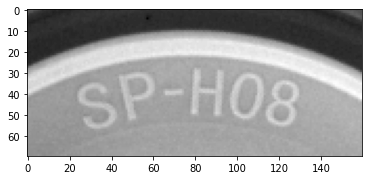

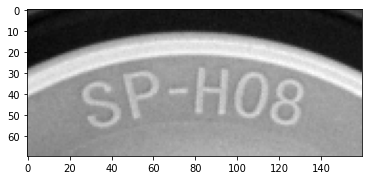

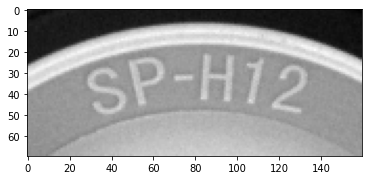

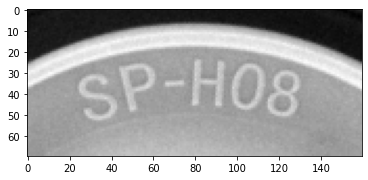

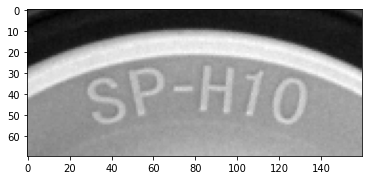

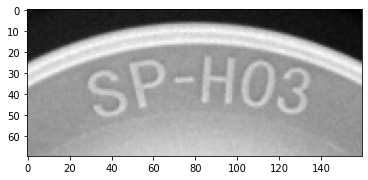

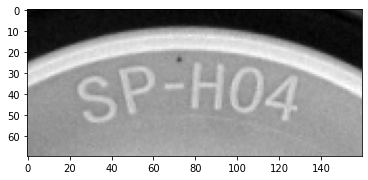

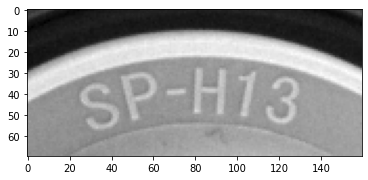

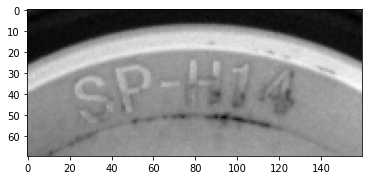

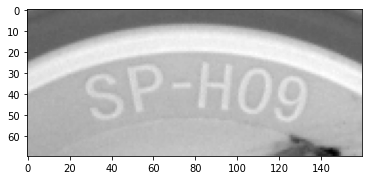

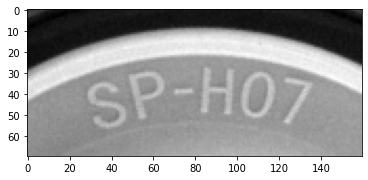

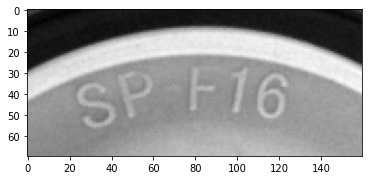

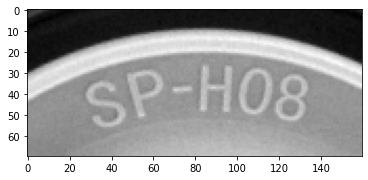

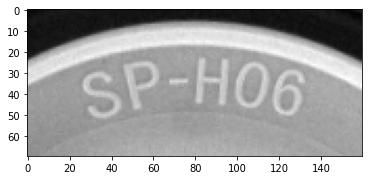

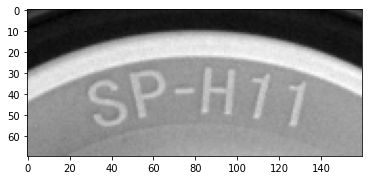

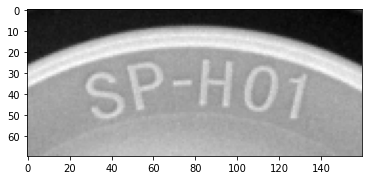

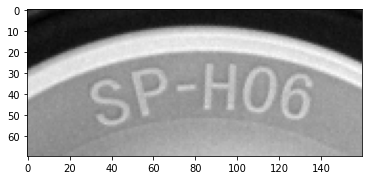

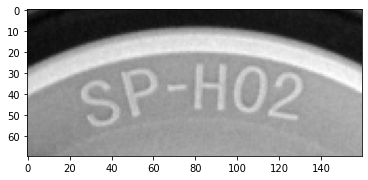

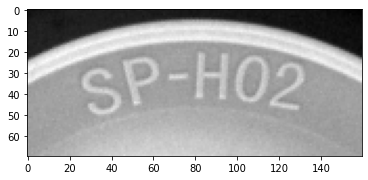

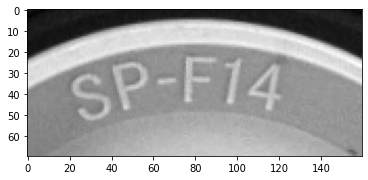

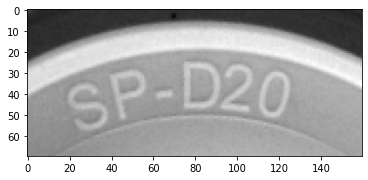

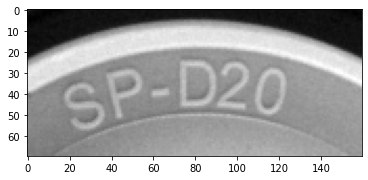

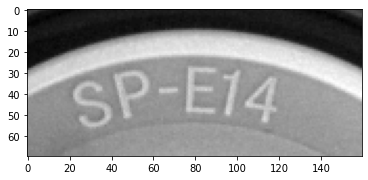

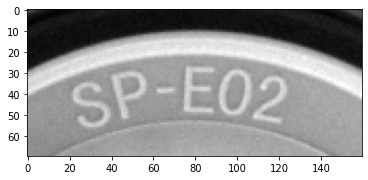

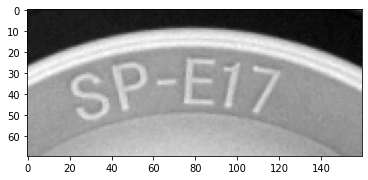

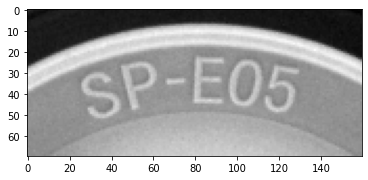

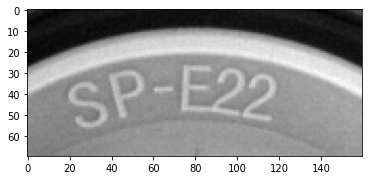

In [6]:
cropped_image = []

for index, rot_img in enumerate(rotated_image):
    
    top_left = (cap_center[index][0][0]-80, cap_center[index][0][1]-cap_center[index][1]+40)
    bottom_right = (cap_center[index][0][0]+80, cap_center[index][0][1]-cap_center[index][1]+110) 
    
    cropped_image.append(rot_img[top_left[1]:bottom_right[1], top_left[0]:bottom_right[0]])
    
    plt.imshow(cropped_image[index], cmap='gray')
    plt.show()

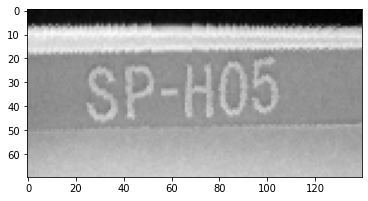

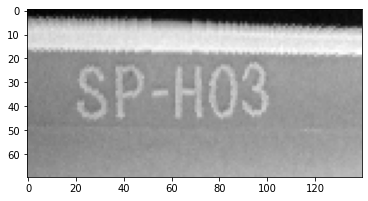

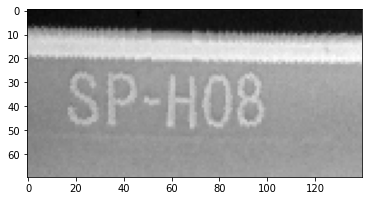

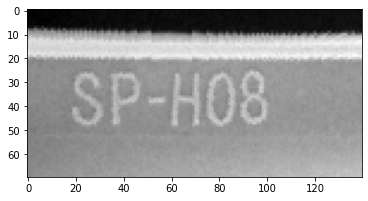

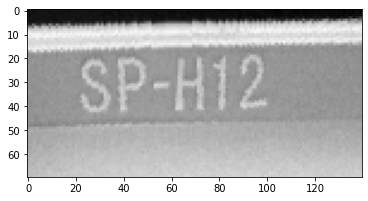

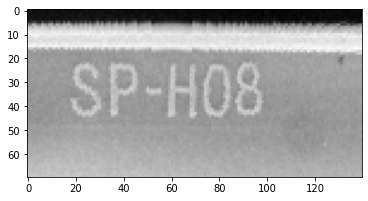

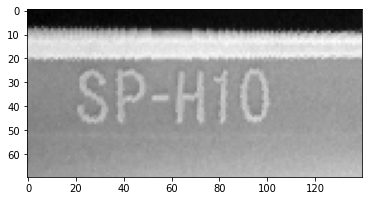

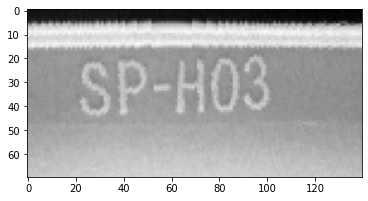

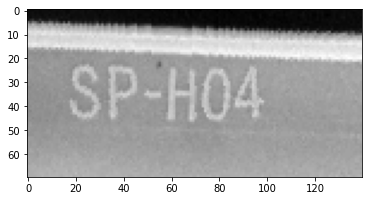

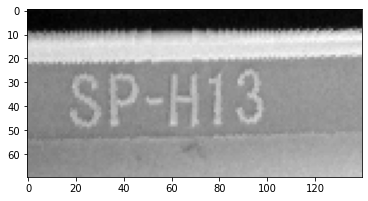

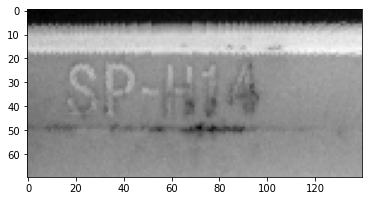

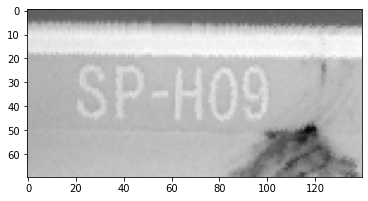

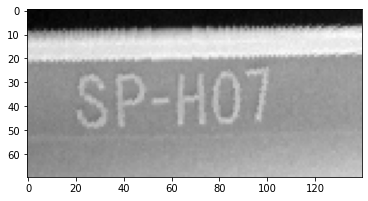

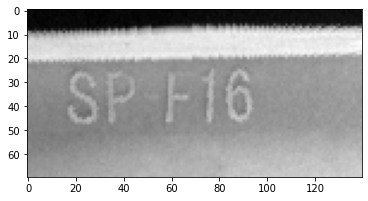

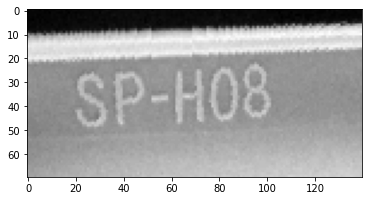

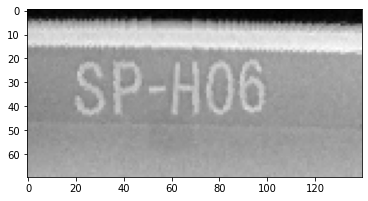

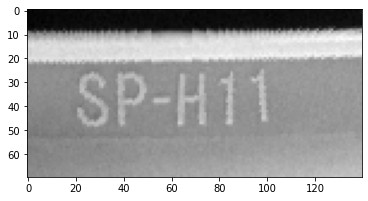

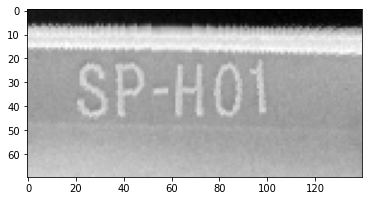

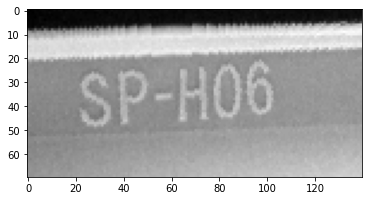

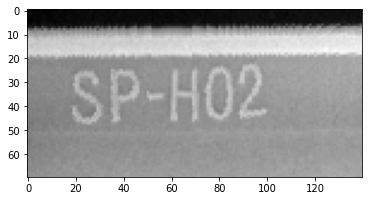

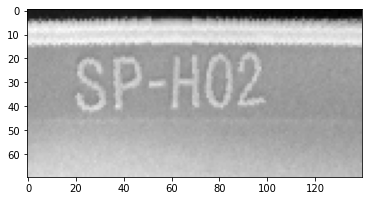

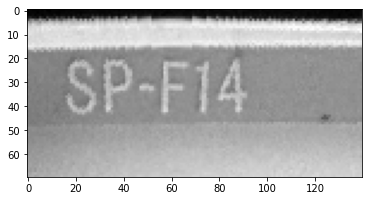

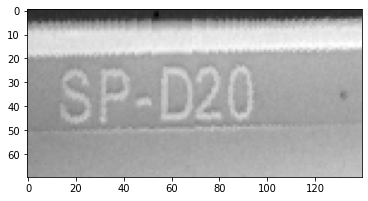

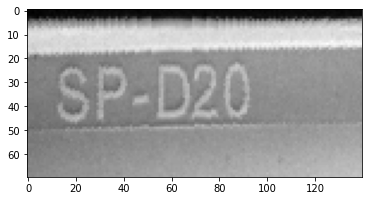

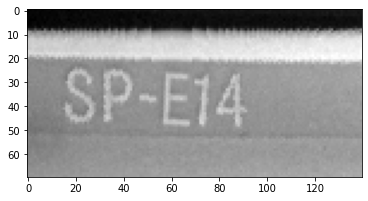

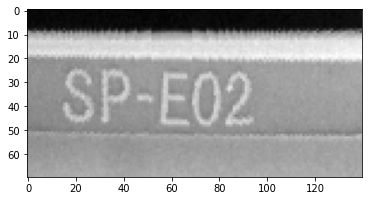

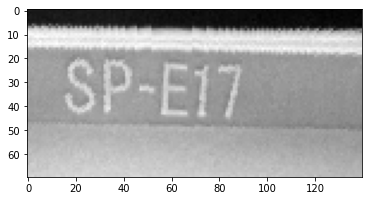

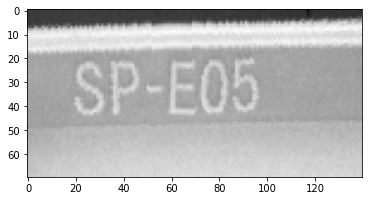

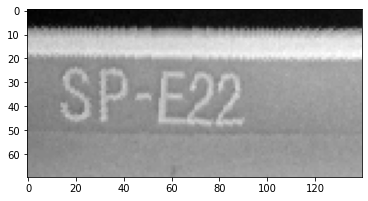

In [7]:
polar_transformed = []

for index, rot_img in enumerate(rotated_image):
    center = cap_center[index][0]
    max_radius = cap_center[index][1]-30
    polar_image = cv2.warpPolar(rot_img, (max_radius, 360*2), center, max_radius, flags=cv2.WARP_POLAR_LINEAR)
    polar_transformed.append(cv2.rotate(polar_image, cv2.ROTATE_90_COUNTERCLOCKWISE))
#     plt.imshow(polar_transformed[index], cmap='gray')
#     plt.show()

rectified_cropped = []

for index, pol_img in enumerate(polar_transformed):
    rectified_cropped.append(pol_img[10:10+70, 2*240:2*(240+70)])
    
    plt.imshow(rectified_cropped[index], cmap='gray')
    plt.show()